In [1]:
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
sys.path.append('../source/endmembers')

In [2]:
import copy
import math
import time
import random
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy import linalg
from collections import deque
from numpy.random import rand
from numpy import linalg as la
import matplotlib.pyplot as plt
from sklearn import preprocessing
import helpers.auxiliar as auxiliar

# Matlab Engine

In [3]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath(r'../source/endmembers/helpers',nargout=0)
eng.addpath(r'../source/endmembers/helpers/SEDUMI',nargout=0)
eng.addpath(r'../source/endmembers/helpers/YALMIP',nargout=0)

# Classical

In [4]:
def PPI(Y, d, q, parameters, numSkewers=None, ini_skewers=None):
    start_time = time.time()
    M = Y
    if numSkewers == None:
        numSkewers = 3*q
    M = np.matrix(M, dtype=np.float32)
    p, N = M.shape
    u = np.transpose(np.transpose(M).mean(axis=0))
    Mm = M - np.kron(np.ones((1,N)), u)
    if ini_skewers == None:
        skewers = np.random.rand(p, numSkewers)
    else:
        skewers = ini_skewers
    votes = np.zeros((N, 1))
    for kk in range(numSkewers):
        tmp = abs(skewers[:,kk]*Mm)
        idx = np.argmax(tmp)
        votes[idx] = votes[idx] + 1
    max_idx = np.argsort(votes, axis=None)
    end_member_idx = max_idx[-q:][::-1]
    U = M[:, end_member_idx]
    M = Y[:,end_member_idx]
    duration = time.time() - start_time
    return M, duration, [end_member_idx]

In [5]:
def NFINDR(Y, d, q, parameters, transform=None, maxit=None, ATGP_init=True):  
    start_time = time.time()
    data = Y
    nsamples, nvariables = data.shape
    if maxit == None:
        maxit = 5*q
    if transform == None:
        transform = data
        transform = auxiliar._PCA_transform(data, q-1)
    else:
        transform = transform
    TestMatrix = np.zeros((q, q), dtype=np.float32, order='F')
    TestMatrix[0,:] = 1
    IDX = None
    if ATGP_init == True:
        induced_em, idx = auxiliar.ATGP(transform, q)
        IDX = np.array(idx, dtype=np.int64)
        for i in range(q):
            TestMatrix[1:q, i] = induced_em[i]
    else:
        IDX =  np.zeros((q), dtype=np.int64)
        for i in range(q):
            idx = int(math.floor(random.random()*nsamples))
            TestMatrix[1:q, i] = transform[idx]
            IDX[i] = idx
    actualVolume = 0
    it = 0
    v1 = -1.0
    v2 = actualVolume
    while it <= maxit and v2 > v1:
        for k in range(q):
            for i in range(nsamples):
                TestMatrix[1:q, k] = transform[i]
                volume = math.fabs(linalg._flinalg.sdet_c(TestMatrix)[0])
                if volume > actualVolume:
                    actualVolume = volume
                    IDX[k] = i
            TestMatrix[1:q, k] = transform[IDX[k]]
        it = it + 1
        v1 = v2
        v2 = actualVolume
    E = np.zeros((len(IDX), nvariables), dtype=np.float32)
    Et = np.zeros((len(IDX), q-1), dtype=np.float32)
    for j in range(len(IDX)):
        E[j] = data[IDX[j]]
        Et[j] = transform[IDX[j]]
    M = Y[:,IDX]
    duration = time.time() - start_time
    return M, duration, [None]

In [6]:
def SGA(Y, d, q, parameters):
    imagecube = matlab.double(Y.reshape((d[0],d[1],d[2])).tolist())
    response = eng.sga(imagecube,q,nargout=2)
    indices = response[0]
    duration = response[1]
    indices = np.array(indices).astype(int)
    indices = [i[0] for i in indices]
    M = Y[:,indices]
    return M, duration, [None]

In [7]:
def VCA(Y, d, q, verbose=False, snr_input=0):
    R = q
    if len(Y.shape)!=2:
        sys.exit('Input data must be of size L (number of bands i.e. channels) by N (number of pixels)')
    [L, N]=Y.shape   # L number of bands (channels), N number of pixels
    R = int(R)
    if (R<0 or R>L):  
        sys.exit('ENDMEMBER parameter must be integer between 1 and L')
    start_time = time.time()
    if snr_input==0:
        y_m = np.mean(Y,axis=1,keepdims=True)
        Y_o = Y - y_m           # data with zero-mean
        Ud  = linalg.svd(sp.dot(Y_o,Y_o.T)/float(N))[0][:,:R]  # computes the R-projection matrix 
        x_p = sp.dot(Ud.T, Y_o)                 # project the zero-mean data onto p-subspace
        SNR = auxiliar.estimate_snr(Y,y_m,x_p)
    if verbose:
        print("SNR estimated = {}[dB]".format(SNR))
    else:
        SNR = snr_input
    if verbose:
        print("input SNR = {}[dB]\n".format(SNR))
    SNR_th = 15 + 10*sp.log10(R)
    if SNR < SNR_th:
        if verbose:
            print("... Select proj. to R-1")
            d = R-1
            if snr_input==0: # it means that the projection is already computed
                Ud = Ud[:,:d]
            else:
                y_m = sp.mean(Y,axis=1,keepdims=True)
                Y_o = Y - y_m  # data with zero-mean 
                Ud  = linalg.svd(sp.dot(Y_o,Y_o.T)/float(N))[0][:,:d]  # computes the p-projection matrix 
                x_p =  sp.dot(Ud.T,Y_o)                 # project thezeros mean data onto p-subspace
            Yp =  sp.dot(Ud,x_p[:d,:]) + y_m      # again in dimension L
            x = x_p[:d,:] #  x_p =  Ud.T * Y_o is on a R-dim subspace
            c = sp.amax(sp.sum(x**2,axis=0))**0.5
            y = sp.vstack(( x, c*sp.ones((1,N)) ))
        else:
            if verbose:
                print("... Select the projective proj.")
            d = R
            Ud  = linalg.svd(sp.dot(Y,Y.T)/float(N))[0][:,:d] # computes the p-projection matrix 
            x_p = sp.dot(Ud.T,Y)
            Yp =  sp.dot(Ud,x_p[:d,:])      # again in dimension L (note that x_p has no null mean)
            x =  sp.dot(Ud.T,Y)
            u = sp.mean(x,axis=1,keepdims=True)        #equivalent to  u = Ud.T * r_m
            y =  x / sp.dot(u.T,x)
    indice = sp.zeros((R),dtype=int)
    A = sp.zeros((R,R))
    A[-1,0] = 1
    for i in range(R):
        w = sp.random.rand(R,1);   
        f = w - sp.dot(A,sp.dot(linalg.pinv(A),w))
        f = f / linalg.norm(f)
        v = sp.dot(f.T,y)
        indice[i] = sp.argmax(sp.absolute(v))
        A[:,i] = y[:,indice[i]]        # same as x(:,indice(i))
    Ae = Yp[:,indice]
    duration = time.time() - start_time
    M = Y[:,indice]
    return M, duration, [indice]

# Minimum Volume Simplex

In [8]:
def MVSA(Y, d, q, parameters):
    Y_mat = matlab.double(Y.tolist())
    response = eng.mvsa(Y_mat,q,nargout=2)
    M = np.array(response[0])
    duration = response[1]
    return M, duration, [None]

In [9]:
def MVES(Y, d, q, parameters):
    Y_mat = matlab.double(Y.tolist())
    response = eng.mves(Y_mat,q,0,nargout=2)
    M = np.array(response[0])
    duration = response[1]
    return M, duration, [None]

In [10]:
def MVCNMF(Y, d, q, parameters):
    Y_mat = matlab.double(Y.tolist())
    response = eng.mvcnmf(Y_mat,q,nargout=2)
    W = np.array(response[0])
    duration = np.array(response[1])
    return W, duration, [None]

In [11]:
def SISAL(Y, d, q, parameters):
    Y_mat = matlab.double(Y.tolist())
    response = eng.sisal(Y_mat,q,nargout=2)
    M = np.array(response[0])
    duration = np.array(response[1])
    return M,duration, [None]

# Evolutionary

In [12]:
def GAEE (data, dimensions, number_endmembers, parameters):
    from deap import base
    from deap import creator
    from deap import tools
    def princomp(A):
        M = (A-np.mean(A.T, axis=1)).T
        [latent,coeff] = la.eig(np.cov(M))
        score = np.dot(coeff.T,M)
        return coeff, score, latent
    def generate_individual(creator, number_endmembers, number_pixels, number_rows, number_columns):
        individual = np.random.choice(list(range(0,number_pixels)), number_endmembers)
        return creator.individual(individual)
    def random_mutation(individual, number_pixels, number_endmembers, mutation_probability):
        new_individual =  random.sample(set(individual + random.sample(range(0,number_pixels), number_endmembers)), number_endmembers)
        mutant = [new_individual[i] if random.random() < mutation_probability else individual[i] for i in range(0,number_endmembers)]
        return mutant
    def maximize_simplex_volume(indices, data_pca, number_endmembers):
        TestMatrix = np.zeros((number_endmembers,number_endmembers))
        TestMatrix[0,:] = 1
        for i in range(0,number_endmembers):
            TestMatrix[1:number_endmembers,i] = data_pca[:,int(indices[i])]
        volume = np.abs(np.linalg.det(TestMatrix))
        return volume
    def mono_fitness (indices, data_pca, number_endmembers):
        return (maximize_simplex_volume(indices, data_pca, number_endmembers),)
    start_time = time.time()
    [population_size,
     number_generations,
     crossing_probability,
     mutation_probability,
     stop_criteria_MAX,
     tournsize,
     number_epochs,
     selection] = parameters
    random.seed(64)
    number_rows = int(dimensions[0])
    number_columns = int(dimensions[1])
    number_bands = int(dimensions[2])
    number_pixels = number_rows*number_columns
    data = np.asarray(data)
    _coeff, score, _latent = princomp(data.T)
    data_pca = np.squeeze(score[0:number_endmembers-1,:])
    M_list = []
    best_individual_list = []
    epoch_generations_fitness = []
    epoch_generations_population = []
    epoch_current_generation = []
    for ep in range(0,number_epochs):
        creator.create("max_fitness", base.Fitness, weights=(1.0,))
        creator.create("individual", list, fitness=creator.max_fitness)
        toolbox = base.Toolbox()
        toolbox.register("create_individual", generate_individual, creator, number_endmembers,number_pixels,number_rows, number_columns)
        toolbox.register("initialize_population", tools.initRepeat, list, toolbox.create_individual)
        toolbox.register("evaluate_simplex_volume", mono_fitness, data_pca=data_pca, number_endmembers=number_endmembers)
        toolbox.register("cross_twopoints", tools.cxTwoPoint)
        toolbox.register("tournament_select", tools.selTournament, tournsize=tournsize)
        toolbox.register("random_mutation", random_mutation, number_pixels=number_pixels, number_endmembers=number_endmembers, mutation_probability=mutation_probability)
        population = toolbox.initialize_population(n=population_size)
        population_fitnesses = [toolbox.evaluate_simplex_volume(individual) for individual in population]
        for individual, fitness in zip(population, population_fitnesses):
            individual.fitness.values = fitness
        hof = tools.HallOfFame(population_size)
        hof.update(population)
        current_generation = 0
        generations_fitness = []
        generations_population = []
        stop_criteria = deque( maxlen=stop_criteria_MAX)
        stop_criteria.extend(list(range(1,stop_criteria_MAX)))
        while current_generation < number_generations and np.var(np.array(stop_criteria)) > 0.001:
            offspring = list(map(toolbox.clone, population))
            # Crossing
            for child_1, child_2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < crossing_probability:
                    toolbox.cross_twopoints(child_1, child_2)
                    del child_1.fitness.values
                    del child_2.fitness.values
            # Mutation
            for mutant in offspring:
                if random.random() < mutation_probability:
                    toolbox.random_mutation(mutant)
                    del mutant.fitness.values
            # Fitness
            offspring_fitnesses = [toolbox.evaluate_simplex_volume(individual) for individual in offspring]
            for individual, fitness in zip(offspring, offspring_fitnesses):
                individual.fitness.values = fitness
            new_population = population+offspring
            # Selection
            selected = toolbox.tournament_select(new_population, population_size)
            population_selected = list(map(toolbox.clone, selected))
            population[:] = population_selected
            hof.update(population)
            # Statistics
            fits = [ind.fitness.values[0] for ind in population]
            mean_offspring = sum(fits) / len(population)
            generations_fitness.append(np.log10(mean_offspring))
            generations_population.append(population.copy())
            stop_criteria.append(np.log10(mean_offspring))
            current_generation+=1
        best_individual = tools.selBest(population, 1)[0]
        M = data[:,best_individual]
        best_individual_list.append(best_individual)
        epoch_generations_fitness.append(generations_fitness)
        epoch_generations_population.append(generations_population)
        epoch_current_generation.append(current_generation)
        M_list.append(M)
    M_all = np.hstack(M_list)
    
    last_volume = list(map( lambda x: x[-1], epoch_generations_fitness))
    
    indx_max = np.argmax(last_volume)
    indx_min = np.argmin(last_volume)
    indx_med = last_volume.index(np.percentile(last_volume,50,interpolation='nearest'))
    
    if selection == 'min':
        M_result = M_list[indx_min]
    if selection == 'avg':
        M_result = M_list[indx_med]
    if selection == 'max':
        M_result = M_list[indx_max]
    if selection == 'all':
        M_result =  M_all
    
    duration = time.time() - start_time
    
    return M_result, duration, [M_list, best_individual_list, epoch_generations_fitness, epoch_generations_population, epoch_current_generation, hof]

In [13]:
def GAEEII (data, dimensions, number_endmembers, parameters):
    from deap import base
    from deap import creator
    from deap import tools
    def princomp(A):
        M = (A-np.mean(A.T, axis=1)).T
        [latent,coeff] = la.eig(np.cov(M))
        score = np.dot(coeff.T,M)
        return coeff, score, latent
    def affine_projection(Y,p):
        from scipy.sparse.linalg import svds, eigs
        L, N = Y.shape
        Y = np.matrix(Y)
        my = Y.mean(axis=1)
        Y = Y - np.matlib.repmat(my, 1, N)
        Up, D, _vt = svds(Y*Y.T/N, k=p-1)
        Up = np.matrix(Up)
        Y = Up*Up.T*Y
        Y = Y + np.matlib.repmat(my,1,N)
        my_ortho = my-Up*Up.T*my
        aux = my_ortho/np.sqrt(sum(np.square(my_ortho)))
        aux = aux.reshape((aux.shape[0],1))
        Up = np.concatenate((Up, aux), axis=1)
        Y = Up.T*Y
        return Y
    def affine_tranform(Y,p):
        from numpy import linalg as la
        L, N = Y.shape
        d = Y.mean(axis=1)
        U = Y-(d*np.ones((L,N)).T).T
        R = np.dot(U,U.T)
        D,eV = la.eig(R)
        C = eV[:,(L-p+1):]
        Xd = np.dot(la.pinv(C), U)
        Xc =  np.concatenate((Xd, -1*np.ones((1,Xd.shape[1]))), axis=0)
        return Xc
    def generate_individual(creator, number_endmembers, number_pixels, number_rows, number_columns):
        individual = np.random.choice(list(range(0,number_pixels)), number_endmembers)
        return creator.individual(individual)
    def gaussian_mutation(individual, toolbox, number_rows, number_columns):
        gene_x = (np.array(individual) / number_rows).astype(int)
        gene_y = (np.array(individual) % number_rows)
        mut_x = abs(toolbox.gaussian_mutation_op(gene_x.copy())[0] % number_columns-1)
        mut_y = abs(toolbox.gaussian_mutation_op(gene_y.copy())[0] % number_rows-1)
        mutant = mut_x*number_rows+mut_y
        return creator.individual(mutant)
    def simplex_volume(indices, data_pca, number_endmembers):
        TestMatrix = np.zeros((number_endmembers,number_endmembers))
        for i in range(0,number_endmembers):
            TestMatrix[0:number_endmembers,i] = data_proj[:,int(indices[i])]
        volume = np.abs(np.linalg.det(TestMatrix))
        return volume
    def mono_fitness (indices, data_proj, number_endmembers):
        return (simplex_volume(indices, data_proj, number_endmembers),)
    def cross_prob(ind_a, ind_b, mate_prob):
        new_ind_a = []
        new_ind_b = []
        for k in range(0,len(ind_a)):
            if rand() < mate_prob:
                new_ind_a.append(ind_b[k])
            else:
                new_ind_a.append(ind_a[k])
            if rand() < mate_prob:
                new_ind_b.append(ind_a[k])
            else:
                new_ind_b.append(ind_b[k])
        return (creator.individual(new_ind_a),creator.individual(new_ind_b)) 
    
    start_time = time.time()
    
    [population_size,
     number_generations,
     crossing_probability,
     mutation_probability,
     stop_criteria_MAX,
     tournsize,
     number_epochs,
     selection] = parameters
    
    random.seed(64)
    
    number_rows = int(dimensions[0])
    number_columns = int(dimensions[1])
    number_bands = int(dimensions[2])
    number_pixels = number_rows*number_columns
    sigma_MAX = max(number_rows, number_generations)
    
    data = np.asarray(data)
    _coeff, score, _latent = princomp(data.T)
    data_proj = np.squeeze(score[0:number_endmembers,:])

    M_list = []
    best_individual_list = []
    epoch_generations_fitness = []
    epoch_generations_population = []
    epoch_current_generation = []
    
    for ep in range(0,number_epochs):
        creator.create("fitness", base.Fitness, weights=(1.0,))
        creator.create("individual", list, fitness=creator.fitness)
        
        toolbox = base.Toolbox()
        
        toolbox.register("create_individual", generate_individual, creator, number_endmembers,number_pixels, number_rows, number_columns)
        toolbox.register("initialize_population", tools.initRepeat, list, toolbox.create_individual)
        toolbox.register("evaluate_individual", mono_fitness, data_proj=data_proj, number_endmembers=number_endmembers)
    
        toolbox.register("cross_prob", cross_prob, mate_prob=crossing_probability)
        
        toolbox.register("tournament_select", tools.selTournament, tournsize=tournsize)
        
        toolbox.register("gaussian_mutation_op", tools.mutGaussian, mu=0, sigma=0, indpb=mutation_probability)
        toolbox.register("gaussian_mutation", gaussian_mutation, toolbox=toolbox, number_rows=number_rows, number_columns=number_columns)
        
        population = toolbox.initialize_population(n=population_size)
        population_fitnesses = [toolbox.evaluate_individual(individual) for individual in population]
        for individual, fitness in zip(population, population_fitnesses):
            individual.fitness.values = fitness
            
        hof = tools.HallOfFame(population_size)
        hof.update(population)
        
        current_generation = 0
        current_sigma = sigma_MAX
        
        generations_fitness = []
        generations_population = []
        
        stop_criteria = deque( maxlen=stop_criteria_MAX)
        stop_criteria.extend(list(range(1,stop_criteria_MAX)))
        
        while current_generation < number_generations and np.var(np.array(stop_criteria)) > 0.001: 
            
            toolbox.unregister("gaussian_mutation_op")
            toolbox.register("gaussian_mutation_op", tools.mutGaussian, mu=0, sigma=current_sigma, indpb=mutation_probability)
            
            offspring = list(map(toolbox.clone, population))
            crossed_offspring = []
            # Crossing
            
            for child_1, child_2 in zip(offspring[::2], offspring[1::2]):
                child_a, child_b = toolbox.cross_prob(child_1, child_2)
                del child_a.fitness.values
                del child_b.fitness.values
                crossed_offspring.append(child_a)
                crossed_offspring.append(child_b)
                
            # Mutation
            for mu in range(0,len(crossed_offspring)):
                mutant = toolbox.gaussian_mutation(crossed_offspring[mu])
                del mutant.fitness.values
                crossed_offspring[mu] = mutant
                
            # Fitness
            crossed_offspring_fitnesses = [toolbox.evaluate_individual(individual) for individual in crossed_offspring]
            for individual, fitness in zip(crossed_offspring, crossed_offspring_fitnesses):
                individual.fitness.values = fitness
                
            new_population = population+crossed_offspring
            
            # Selection
            selected = toolbox.tournament_select(new_population, population_size)
            population_selected = list(map(toolbox.clone, selected))
            
            population[:] = population_selected
            hof.update(population)
            
            # Statistics
            fits = [ind.fitness.values[0] for ind in population]
            mean_offspring = sum(fits) / len(population)
            
            generations_fitness.append(np.log10(mean_offspring))
            generations_population.append(population.copy())
            
            stop_criteria.append(np.log10(mean_offspring))
            
            current_generation+=1
            current_sigma = sigma_MAX/((current_generation+1)/4)
            
        best_individual = tools.selBest(population, 1)[0]
        
        M = data[:,best_individual]
        best_individual_list.append(best_individual)
        M_list.append(M)
        
        epoch_generations_fitness.append(generations_fitness)
        epoch_generations_population.append(generations_population)
        epoch_current_generation.append(current_generation)
        
    M_all = np.hstack(M_list)
    
    last_volume = list(map( lambda x: x[-1], epoch_generations_fitness))
    
    indx_max = np.argmax(last_volume)
    indx_min = np.argmin(last_volume)
    indx_med = last_volume.index(np.percentile(last_volume,50,interpolation='nearest'))
    
    if selection == 'min':
        M_result = M_list[indx_min]
    if selection == 'avg':
        M_result = M_list[indx_med]
    if selection == 'max':
        M_result = M_list[indx_max]
    if selection == 'all':
        M_result =  M_all
    
    duration = time.time() - start_time
    
    return M_result, duration, [M_list, best_individual_list, epoch_generations_fitness, epoch_generations_population, epoch_current_generation, hof]

In [14]:
[Y,
 img,
 dimensions, 
 number_endmembers,
 ground_truth,
 ground_truth_plot,
 endmembers_names,
 dimensions_plot,
 bandsSelection,
 dataset_name] = auxiliar.load_legendre_dataset(80)

In [15]:
results = []
ppi_m, results, results_df = auxiliar.monte_carlo(results, Y, dimensions, number_endmembers, PPI, [], 'PPI', ground_truth, endmembers_names, dataset_name, 5)
nfindr_m, results, results_df = auxiliar.monte_carlo(results, Y, dimensions, number_endmembers, NFINDR, [], 'NFINDR', ground_truth, endmembers_names, dataset_name, 5)
sga_m, results, results_df = auxiliar.monte_carlo(results, Y, dimensions, number_endmembers, SGA, [], 'SGA', ground_truth, endmembers_names, dataset_name, 5)
vca_m, results, results_df = auxiliar.monte_carlo(results, Y, dimensions, number_endmembers, VCA, [], 'VCA', ground_truth, endmembers_names, dataset_name, 5)
# mves_m, results, results_df = auxiliar.monte_carlo(results, Y, dimensions, number_endmembers, MVES, [],'MVES', ground_truth, endmembers_names, dataset_name, 5)
mvsa_m, results, results_df = auxiliar.monte_carlo(results, Y, dimensions, number_endmembers, MVSA, [], 'MVSA', ground_truth, endmembers_names, dataset_name, 5)
# mvcnmf_m, results, results_df = auxiliar.monte_carlo(results, Y, dimensions, number_endmembers, MVCNMF, [], 'MVCNMF', ground_truth, endmembers_names, dataset_name, 5)
# sisal_m, results, results_df = auxiliar.monte_carlo(results, Y, dimensions, number_endmembers, SISAL, [], 'SISAL', ground_truth, endmembers_names, dataset_name, 5)
gaee_m, results, results_df = auxiliar.monte_carlo(results, Y, dimensions, number_endmembers, GAEE, [100, 100, 0.3, 0.7, 10, 3, 1, 'max'],'GAEE', ground_truth, endmembers_names, dataset_name, 5)
# gaee_m_min, results, results_df = auxiliar.monte_carlo(results, Y, dimensions, number_endmembers, GAEE, [100, 100, 0.3, 0.7, 10, 3, 15, 'min'],'GAEE-min', ground_truth, endmembers_names, dataset_name, 5)
# gaee_m_max, results, results_df = auxiliar.monte_carlo(results, Y, dimensions, number_endmembers, GAEE, [100, 100, 0.3, 0.7, 10, 3, 15, 'max'],'GAEE-max', ground_truth, endmembers_names, dataset_name, 5)
# gaee_m_avg, results, results_df = auxiliar.monte_carlo(results, Y, dimensions, number_endmembers, GAEE, [100, 100, 0.3, 0.7, 10, 3, 15, 'avg'],'GAEE-avg', ground_truth, endmembers_names, dataset_name, 5)
# gaee_m_all, results, results_df = auxiliar.monte_carlo(results, Y, dimensions, number_endmembers, GAEE, [100, 100, 0.3, 0.7, 10, 3, 15, 'all'],'GAEE-all', ground_truth, endmembers_names, dataset_name, 5)
# gaeeii_m, results, results_df = auxiliar.monte_carlo(results, Y, dimensions, number_endmembers, GAEEII, [100, 100, 0.3, 0.7, 10, 3, 1 ,'max'],'GAEEII', ground_truth, endmembers_names, dataset_name, 5)
# gaeeii_m_min, results, results_df = auxiliar.monte_carlo(results, Y, dimensions, number_endmembers, GAEEII, [100, 100, 0.3, 0.7, 10, 3, 15 ,'min'],'GAEEII-min', ground_truth, endmembers_names, dataset_name, 5)
# gaeeii_m_max, results, results_df = auxiliar.monte_carlo(results, Y, dimensions, number_endmembers, GAEEII, [100, 100, 0.3, 0.7, 10, 3, 15 ,'max'],'GAEEII-max', ground_truth, endmembers_names, dataset_name, 5)
# gaeeii_m_avg, results, results_df = auxiliar.monte_carlo(results, Y, dimensions, number_endmembers, GAEEII, [100, 100, 0.3, 0.7, 10, 3, 15 ,'avg'],'GAEEII-avg', ground_truth, endmembers_names, dataset_name, 5)
gaeeii_m_all, results, results_df = auxiliar.monte_carlo(results, Y, dimensions, number_endmembers, GAEEII, [100, 100, 0.3, 0.7, 10, 3, 15 ,'all'],'GAEEII', ground_truth, endmembers_names, dataset_name, 5)


100%|██████████| 5/5 [01:24<00:00, 16.93s/it]


In [16]:
results_df.to_pickle("./"+dataset_name+".pkl")

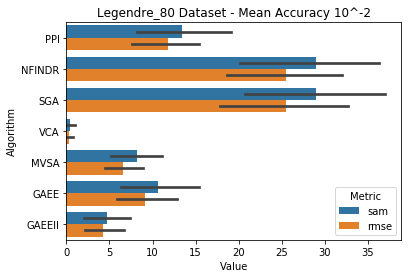

In [17]:
auxiliar.plot_total_mean_accurary(results_df, dataset_name)

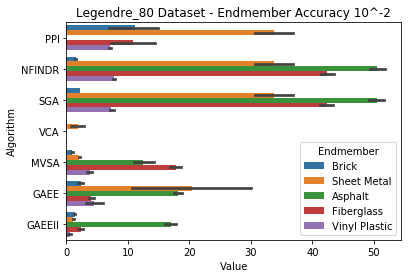

In [18]:
auxiliar.plot_endmembers_mean_accurary(results_df, dataset_name)

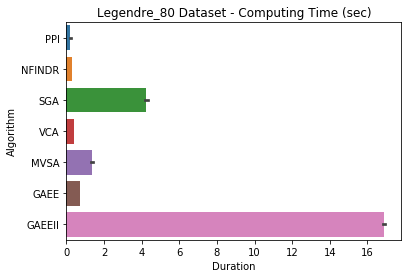

In [19]:
auxiliar.plot_mean_computing_time(results_df, dataset_name)

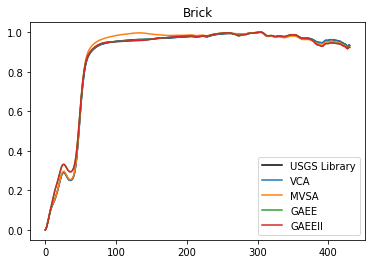

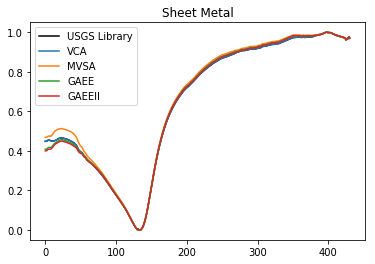

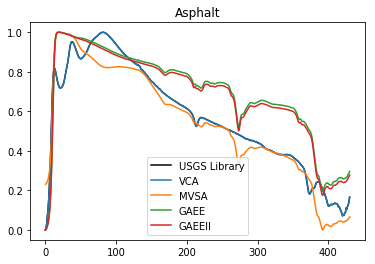

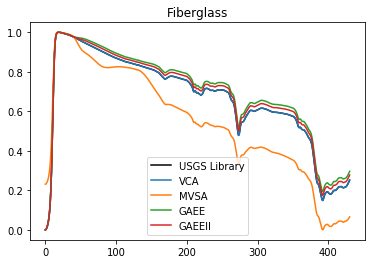

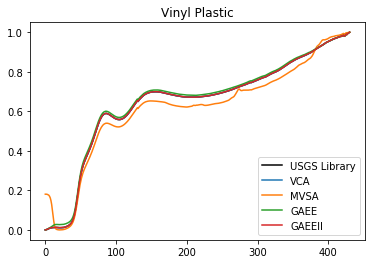

In [20]:
auxiliar.plot_endmembers([vca_m, mvsa_m, gaee_m, gaeeii_m_all], ground_truth, ["VCA", "MVSA", "GAEE", "GAEEII"],number_endmembers, endmembers_names)

In [21]:
# M, duration, [M_list, best_individual,
#  generations_fitness,
#  generations_population,
#  current_generation,
#  hof] = GAEE(Y, dimensions, number_endmembers, [100, 100, 0.3, 0.7, 20, 3, 15 ,'max'])

In [22]:
# plt.figure()
# for i in range(0,15):
#     plt.plot( list(range(0,current_generation[i])),generations_fitness[i])
# plt.title("GAEE Convergence")
# plt.ylabel('log10(simplex_volume)')
# plt.xlabel('number of generations')
# # plt.legend(list(range(0,len(generations_fitness))))
# plt.tight_layout()

In [23]:
# last_volume = list(map( lambda x: x[-1], generations_fitness))
# indx = np.argmax(last_volume)
# print('Epoch with max volume: ',indx)
# aux = auxiliar.normalize_data(M_list[indx])
# for j in range(0,number_endmembers):
#     plt.plot(aux[:,j])

In [24]:
# aux_m = []
# for i in generations_population[len(generations_population)-1]:
#     aux_m.extend(i)
# aux_m = list(map(lambda x: tuple(x),aux_m))
# individuals = set(aux_m)

In [25]:
# volume, erro_sg = auxiliar.convergence_volume_erro(individuals,Y,ground_truth,number_endmembers)
# plt.plot(erro_sg,volume)
# plt.title("GAEE Population (Simplex Volume x SAD)")
# plt.ylabel('SAD (Savitzky-Golay Filter)')
# plt.xlabel('Simplex Volume');

In [26]:
# M, duration, [M_list, best_individual,
#  generations_fitness,
#  generations_population,
#  current_generation,
#  hof] = GAEE(Y, dimensions, number_endmembers, [100, 100, 0.5, 0.7, 40, 3, 100 ,'all'])

In [27]:
# plt.figure()
# for i in range(0,15):
#     plt.plot( list(range(0,current_generation[i])),generations_fitness[i])
# plt.title("GAEEII Convergence")
# plt.ylabel('log10(simplex_volume)')
# plt.xlabel('number of generations')
# # plt.legend(list(range(0,len(generations_fitness))))
# plt.tight_layout()

In [28]:
# aux_m = list(map(lambda x: tuple(x),best_individual))
# individuals = set(aux_m)

In [29]:
# volume, erro_sg = auxiliar.convergence_volume_erro(individuals,Y,ground_truth,number_endmembers)
# plt.plot(erro_sg,volume)
# plt.title("GAEEII Epochs (Simplex Volume x SAD)")
# plt.ylabel('SAD (Savitzky-Golay Filter)')
# plt.xlabel('Simplex Volume');